## INFO284 - Group exam

Your tasks are:

#### Preprocessing: 
Get to understand the data and remove columns and rows that you do not find useful for your machine learning models. It is possible to for example focus on one type of gear, one or a few species, group categories of species, etc. etc. This will help to reduce
the data set you are working on. Understanding data and preparing them for model building
is a main task of machine learning.

#### Supervised learning: 
Build at least three machine learning models to predict or classify catch
data related to a fishery operation, i.e. species caught, amounts of one fish species (sums of amounts is also possible), or other features related to fish catches. One of the models needs to be a deep learning model.

#### Unsupervised learning: 
Build a clustering model for the data set. You may use a different preprocessing for this task than for the data in task b).


You shall deliver code in the form of a well commented Jupyter notebook. This code needs to run on the original data set, so any preprocessing you choose to do needs to be programmed in Python and included in the notebook. The code shall in the end return the results of your experiments with your chosen models. You need to explain

- Important and relevant properties of the data
- how you preprocessed data like which features you selected, did you do dimension reduction 
- how you reformatted data, etc.
- how you decided on parameters for your machine learning models,
- if you used any regularization techniques? In case how.
- how the methods were measured and compared

Please inform about any special Python libraries that need to be installed to make your code runnable.

Finally, as a concluding comment in the Jupyter notebook, you need to write a summary of your results, and discuss consequences of such results.

It is not necessarily so that high scores for machine learning models will give a good grade on your report, or vice versa, low scores a bad grade. What counts is a well-argued, well described, and smart machine learning investigation from start to end. The problem may in fact be of such nature that it is not possible to get really good results on these data.
Final note: These data are prepared for this course and are shared with you in confidence that you do not share them in any way but use them only for the purpose of this exam.


## 1: Importerer nødvendige biblioteker
Leser csv.

In [300]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
import time

df = pd.read_csv("GroupExam2024_data_and_documentation/elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv", sep=';', decimal=',')

### 2: Splitte datasett


In [301]:
# Splitter datasettet i train_df og test_df
train_df, test_df = train_test_split(df, test_size = 0.15)

### 3: Utforske datasettet:

In [302]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 259618 entries, 241698 to 19575
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Melding ID                259618 non-null  int64  
 1   Meldingstidspunkt         259618 non-null  object 
 2   Meldingsdato              259618 non-null  object 
 3   Meldingsklokkeslett       259618 non-null  object 
 4   Starttidspunkt            259618 non-null  object 
 5   Startdato                 259618 non-null  object 
 6   Startklokkeslett          259618 non-null  object 
 7   Startposisjon bredde      259618 non-null  float64
 8   Startposisjon lengde      259618 non-null  float64
 9   Hovedområde start (kode)  257900 non-null  float64
 10  Hovedområde start         256093 non-null  object 
 11  Lokasjon start (kode)     257900 non-null  float64
 12  Havdybde start            259618 non-null  int64  
 13  Stopptidspunkt            259618 non-null  ob

Av df.info ser vi de ulike kolonnene og hvilken datatype de er. og hvor mange "non-null" verdier som eksisterer. Kan se her at det eksisterer null-verdier i de fleste kolonner. Dette renses senere. Konverterer datatype etter å ha filtrert ut de uaktuelle kolonnene.

Basert på datasettet og kolonnene vi har sett på så ønsker vi å predikere rundvekt av en aktivitet.


Ser av datasettet hvordan dataen er strukturert. 
**Organisering av datasettet**
Hver rad representerer en fangst av art. Flere rader er registrert med samme starttidspunkt eller stopptidspunkt. De ulike fangstene som er gjort på samme tidspunkt med samme melding ID kommer fra samme fiskeaktivitet. Videre så har de ulike aktivitetene som er gjort på samme Melding ID samme meldingsdato, og kommer fra samme båt.

**Bruttotonnasje 1969 og Bruttotonnasje annen**
Vi ser også at kolonnen Bruttotonnasje annen og bruttotonnasje 1969 ser ut til å utfylle hverandre.Med bruttotonnasje menes det totale volumet av hulrom i båten. Det kan ikke helt sammenlignes med lastekapasitet, men kan være en indikator. Bruttotonnasje 1969 er standarden i dag for registrering av dette målet av båten. Bruttotonnasje annen viser de båtene som er registrert gjennom andre systemer enn standarden.

Vi antar at selv om det antakelig er forskjeller i hvordan disse båtene har målt sin Bruttotonnasje, så er det sannsynligvis også så mange likheter at det ikke har betydning. Dette er det kanskje nødvendig å undersøke nermere dersom man vil ha en mer nøyaktig analyse av dataene. Disse to kolonnene vil vi derfor slå sammen. til en felles kolonne.

Hva leter vi etter?
Siden dette er en samling av fiskeridata, så tenker vi det er interessant å se nærmere på fangstdataene. Her kunne vi hatt mange interessante innfallsvinkler, men vi ønsker å se om det er mulig å predikere rundvekt av en bestemt art gitt den informasjonen vi har. Siden fiskere bruker ulike redskaper for å fange fisk kan vi kan anta at noen redskaper og metoder er mer egnet for å fange bestemte arter. For eksempel så brukes ikke teiner for å fange torsk eller trål for å fange makrell (Må sjekke opp i). I tillegg vet vi også at det foregår fiske etter ulike arter på ulike steder og tidspunkt. Skreifiske for eksempel foregår i bestemte tidsrom etter bestemte arter, med bestemte redskaper. Videre kan vi anta at det samme gjelder for for eksempel sildefiske. Kunnskap om hvordan, hvor og hva som fiskes etter er derfor viktig for å forstå datasettet. Videre avsnitt bruker vi på å undersøke informasjon omkring fisket.


In [303]:
# Først undersøker vi hvor mange registreringer det er av de ulike fisketypene og hvor mye det fiskes av hver.

species_weight_sum = train_df.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(train_df['Art - gruppe'].value_counts())
print(species_weight_sum)

Art - gruppe
Torsk                                       48084
Annen torskefisk                            38445
Sei                                         36136
Hyse                                        33310
Annen flatfisk, bunnfisk og dypvannsfisk    21398
Uer                                         16707
Steinbiter                                  13797
Dypvannsreke                                11686
Blåkveite                                    6893
Snøkrabbe                                    5158
Sild, annen                                  5122
Skater og annen bruskfisk                    3454
Makrell                                      2521
Kolmule                                      2417
Øyepål                                       1879
Annen pelagisk fisk                          1546
Vassild og strømsild                         1394
Andre skalldyr, bløtdyr og pigghuder         1143
Lodde                                        1004
Tobis og annen sil                   

Her ser vi en hovedvekt av fiske etter Torsk. På en annenplass kommer sei. Reke er det også mye aktivitet rundt.

In [304]:
# Gjør samme undersøkelse av reskaper.

redskap_weight_sum = train_df.groupby('Redskap FDIR')['Rundvekt'].sum().sort_values(ascending=False)
print(train_df['Redskap FDIR'].value_counts())
print(redskap_weight_sum)

Redskap FDIR
Bunntrål                                  102435
Snurrevad                                  43894
Andre liner                                37346
Reketrål                                   19089
Udefinert garn                             16374
Udefinert trål                             13470
Snurpenot/ringnot                          10854
Teiner                                      5787
Bunntrål par                                2824
Dobbeltrål                                  2386
Flytetrål                                   2333
Flytetrål par                               1284
Settegarn                                    542
Harpun og lignende uspesifiserte typer       421
Annet                                        397
Juksa/pilk                                    16
Dorg/harp/snik                                12
Name: count, dtype: int64
Redskap FDIR
Snurpenot/ringnot                         659605121.0
Flytetrål                                 402852984.0
Bunntrå

Her ser vi at de to mest brukte fangstredskapene er Bunntrål og Snurrevad. Videre er andre liner, reketrål og andre liner høyt oppe på listen. fra fiskeridirektoratet (kilde) vet vi at Bunntrål og Snurrevad er garn/not som blir slept langs bunnen av sjøen og samler opp fisk på den måten. Andre liner (dersom vi har forstått det riktig) er fiske med agn og krok som gjerne slepes bak båten. 

Det som er naturlig å undersøke nå er hvordan sammensetningen av fisk er med de ulike fangsmetodene, og hvor det er vanlig at de blir brukt.

In [305]:
# Ser etter hvilke fisk som blir fisket med Bunntrål:
condition = train_df[train_df['Redskap FDIR'] == 'Bunntrål']
species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Torsk                                       19890
Sei                                         15545
Hyse                                        14129
Annen torskefisk                            12729
Uer                                         12040
Annen flatfisk, bunnfisk og dypvannsfisk     7246
Dypvannsreke                                 6358
Steinbiter                                   6226
Blåkveite                                    4379
Skater og annen bruskfisk                     698
Øyepål                                        617
Andre skalldyr, bløtdyr og pigghuder          516
Kolmule                                       415
Vassild og strømsild                          399
Annen pelagisk fisk                           351
Sild, annen                                   268
Makrell                                       177
Tobis og annen sil                            153
Haifisk                                        56
Lodde                                

In [306]:
# Ser etter hvilke fisk som blir fisket med Snurrevad:
condition = train_df[train_df['Redskap FDIR'] == 'Snurrevad']

species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Torsk                                       13870
Hyse                                        10213
Sei                                          9520
Annen flatfisk, bunnfisk og dypvannsfisk     3608
Annen torskefisk                             3497
Steinbiter                                   1084
Uer                                           693
Blåkveite                                     319
Sild, annen                                    29
Makrell                                        21
Dypvannsreke                                   10
Skater og annen bruskfisk                       9
Lodde                                           8
Andre skalldyr, bløtdyr og pigghuder            4
Haifisk                                         3
Annen pelagisk fisk                             1
Sjøpattedyr                                     1
Name: count, dtype: int64 Art - gruppe
Torsk                                       48740907.0
Sei                                        

In [307]:
# Ser etter hvilke fisk som blir fisket med andre liner:
condition = train_df[train_df['Redskap FDIR'] == 'Andre liner']
species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Annen torskefisk                            9496
Torsk                                       6240
Steinbiter                                  5716
Hyse                                        5638
Uer                                         2796
Sei                                         2138
Annen flatfisk, bunnfisk og dypvannsfisk    1956
Blåkveite                                   1799
Skater og annen bruskfisk                   1500
Haifisk                                       50
Kongekrabbe, annen                             2
Brunalger                                      1
Name: count, dtype: int64 Art - gruppe
Torsk                                       27959414.0
Hyse                                        20831569.0
Annen torskefisk                            17970403.0
Steinbiter                                   4123427.0
Blåkveite                                    2829597.0
Sei                                           771989.0
Skater og annen bruskfisk     

In [308]:
# Ser etter hvilke fisk som blir fisket med reketrål:
condition = train_df[train_df['Redskap FDIR'] == 'Reketrål']
species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Art - gruppe'].value_counts(), species_weight_sum)

Art - gruppe
Dypvannsreke                                4975
Annen flatfisk, bunnfisk og dypvannsfisk    3372
Annen torskefisk                            2780
Torsk                                       2531
Sei                                         2352
Skater og annen bruskfisk                   1049
Hyse                                         424
Øyepål                                       396
Andre skalldyr, bløtdyr og pigghuder         300
Annen pelagisk fisk                          161
Steinbiter                                   156
Uer                                          155
Blåkveite                                    104
Kolmule                                      104
Vassild og strømsild                          92
Sild, annen                                   23
Makrell                                       20
Haifisk                                       16
Tobis og annen sil                             8
Brunalger                                      1
Mesopel

In [309]:
# Ser etter hvilke fisk som blir fisket med snurpenot, ringnot et fartøy:
condition = train_df[train_df['Redskap FDIR'] == 'Snurpenot/ringnot']
species_weight_sum = condition.groupby('Art - gruppe')['Rundvekt'].sum().sort_values(ascending=False)
print(condition['Hovedart FAO'].value_counts(), species_weight_sum)

Hovedart FAO
Sild                    4719
Sei                     1095
Lodde                   1053
Makrell                  806
Torsk                    644
Brisling                 144
Tobis og annen sil       127
Hestmakrell               80
Kolmule                   58
Strømsild/Vassild         19
Strømsild                 17
Hyse                       7
Vassild                    5
Blåkveite                  3
Makrellstørje              2
Nordlig lysprikkfisk       1
Name: count, dtype: int64 Art - gruppe
Sild, annen                                 307923155.0
Lodde                                       150510120.0
Makrell                                     135981357.0
Sei                                          29578671.0
Kolmule                                      22251480.0
Tobis og annen sil                            4956001.0
Torsk                                         3840282.0
Kystbrisling                                  2263600.0
Annen pelagisk fisk                 

Etter å ha studert de ulike redskapene og hva som blir fisket med de aktuelle, ser vi også konturene av hvordan de blir brukt. Bunntrål er den mest ukritiske fangstmetoden og den tar med seg et større mangfold av fisk enn for eksempel snurrevad som kanskje er naturlig å sammenligne med. Man skulle tro av navnet at en reketrål var mer målrettet i fangsten, og at andelen reker var større i denne sammensetningen, men her kan vi også anta, at siden reker står ganske lavt i næringskjeden, så vil det være naturlig at det er en stor andel av "rovfisker" i miksen. Vi har ikke sett her hvor stor andel av vekten de andre fiskene utgjør

Redskaper:
    Snurpenot/ringnot:
        Dette er det redskapet som det blir fisket desidert mest fisk med, selv om det er mye flere registreringer av andre redskaper. Forklaring her kan være at at med Snurpenot/ringnot blir det fisket mest stimfisk som sild, lodde, makrell osv, som opptrer i stim og dermed er naturlig at man fanger mye av når man først har funnet stimen. Det trenger ikke nødvendigvis bety at det er et mer effektivt fiske.
    Bunntrål:
        Med dette redskapet blir det fisket mest torsk og sei, men også ganske mye av andre arter. Det er det redskapet som vi har undersøkt som har jevnest fordeling arter, som betyr at det er det redskapet som bidrar med mest bifangst.
    Snurrevad:
        Dette redskapet ligner på bunntrål, men det virker som det drives litt mer målrettet fiske med dette. Spredningen av fangst av forskjellige arter er ikke så stor.
    Andre liner:
    Reketrål:
    
Basert på denne infoen er det interessant å dykke videre inn i et bestemt redskap og art og muligens et bestemt område. 


In [310]:
print(train_df['Hovedområde start'].value_counts())

Hovedområde start
Eigersundbanken                  38423
Røstbanken til Malangsgrunnen    24766
Vest-Finnmark                    23599
Øst-Finnmark                     22904
Bjørnøya                         21521
Shetland                         21046
Nordkappbanken                   15809
Vikingbanken                     14134
Skagerrak                        13747
Storegga-Frøyabanken             12647
Helgelandsbanken                  7284
Sentralbanken                     4777
Storbanken                        4103
Thor Iversens Bank                3877
Vestfjorden (Lofoten)             3796
Sentrale Nordsjø                  2868
Hopen                             2746
Vest av Skottland (Hebridene)     1704
Sørlige Norskehav                 1690
Østlige Norskehav                 1648
Admiralityfeltet                  1617
Skolpenbanken                     1588
Gåsebanken                        1454
Storfjord/Hinlopenstredet         1149
Vest-Spitsbergen                  1055
Vest av

Lokasjon:
Det er ingen hemmelighet at fiske etter ulike arter foregår på ulike steder til ulikt tidspunkt, avhengig av hva man ønsker å fiske, og hvor mye. For eksempel har skreifiske i lofoten pågått i tusener av år. Storsilden har også tradisjonelt sett kommet inn til vestlandskysten på vinteren.
https://open-data-fiskeridirektoratet-fiskeridir.hub.arcgis.com/datasets/1b8c3425aaf643e9b2abd3bc70111697/explore

Sei:
Vi har valgt å fokusere på seifiske: I Norge er det hovedsaklig fiske etter to grupper av sei. En gruppe som beiter i havområdene mellom Norge og Skottland https://www.hi.no/hi/temasider/arter/sei-i-nordsjoen og en annen som beiter i kystområdene fra vestlandet til finnmark. https://www.hi.no/hi/temasider/arter/nordaustarktisk-sei.
De er rovfisker og vandrefisk og kan følge sild langt ut i norskehavet. 

Om vi skal fokusere på den nordøstarktiske seien, kan det se ut fra denne informasjon at det kan være lurt å fokusere på hovedområdene fra 0-7 og 28 men uten hovedområde 2. Om vi skal inkludere Nordsjøseien, så kan vi inkludere områdene 40-43, men da beveger vi oss også litt utenfor de de norske områdene.

Videre er det 

Kart over hovedområder. Brukes for å velge ut aktuelle områder.
https://open-data-fiskeridirektoratet-fiskeridir.hub.arcgis.com/datasets/1b8c3425aaf643e9b2abd3bc70111697/explore 



### 4: Filtrere data:

In [311]:
# Lager en betingelse med aktuelle områder.
northeastern = [0, 1, 3, 4, 5, 6, 7, 28]
northeastern_ocean = [30, 34, 37, 39, 12, 36] # For å undersøke om det er noe særlig seifiske utenfor de mer kystnære strøk
northsea = [40, 41, 42, 43] # For å undersøke seifiske
# Legger inn betingelser i train_df.
filtered_train_df = train_df[
    (train_df['Hovedart FAO'] == 'Sei') &
    (train_df['Hovedområde start (kode)'].isin(northeastern)) &
    (train_df['Redskap FDIR'] == 'Bunntrål')
]

# Gjør det samme med test-settet
filtered_test_df = test_df[
    (test_df['Hovedart FAO'] == 'Sei') &
    (test_df['Hovedområde start (kode)'].isin(northeastern)) &
    (test_df['Redskap FDIR'] == 'Bunntrål')
]

filtered_train_df.describe()  # Får her et inntrykk av ekstremverdier og gjennomsnitt.

,Melding ID,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Lokasjon start (kode),Havdybde start,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,...,Redskap FDIR (kode),Hovedart - FDIR (kode),Art - FDIR (kode),Art - gruppe (kode),Rundvekt,Lengdegruppe (kode),Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
count,2.299100e+04,22991.000000,22991.000000,22991.000000,22991.000000,22991.000000,22991.000000,22991.0,22991.000000,22991.000000,...,22991.0,22991.0,22991.000000,22991.000000,22991.000000,22991.000000,22295.000000,696.000000,22991.000000,22991.000000
mean,1.646756e+06,66.704274,12.989225,8.638511,19.149015,-188.903745,255.445261,2018.0,66.720934,13.023190,...,51.0,1032.0,1235.579662,224.977165,2690.003132,4.934366,1947.852164,165.372126,12.904186,57.148302
std,9.425123e+04,4.133171,8.351998,8.334270,13.926389,64.780198,89.514284,0.0,4.143732,8.371767,...,0.0,0.0,452.391118,39.734520,5373.901741,0.286719,1076.453492,16.649783,2.267662,15.182896
min,1.497341e+06,60.001000,2.005000,0.000000,1.000000,-761.000000,6.000000,2018.0,59.647000,1.654000,...,51.0,1032.0,529.000000,201.000000,0.000000,3.000000,197.000000,129.000000,6.980000,19.750000
25%,1.549257e+06,62.832000,5.322000,4.000000,9.000000,-226.000000,194.500000,2018.0,62.834000,5.334000,...,51.0,1032.0,1023.000000,202.000000,76.000000,5.000000,1199.000000,173.000000,12.000000,50.800000
50%,1.665821e+06,67.993000,10.832000,5.000000,15.000000,-183.000000,267.000000,2018.0,68.014000,10.907000,...,51.0,1032.0,1032.000000,203.000000,261.000000,5.000000,1598.000000,173.000000,13.000000,56.800000
75%,1.729002e+06,70.866500,20.565000,7.000000,23.000000,-145.000000,321.000000,2018.0,70.882000,20.591000,...,51.0,1032.0,1034.000000,220.000000,2422.000000,5.000000,2610.000000,173.000000,14.600000,69.800000
max,1.800286e+06,71.998000,32.279000,28.000000,54.000000,1.000000,1706.000000,2018.0,72.060000,32.226000,...,51.0,1032.0,2919.000000,520.000000,86506.000000,5.000000,4427.000000,173.000000,16.700000,81.200000


### 5: Gruppere data:
Vi har valgt å gruppere data etter aktiviteter etter å ha sett igjennom data først. Man kan argumentere for at det ville vært lurt å gjort det før i prosjektet, men mulige utfordringer da er å ikke kunne fange opp nyansene i datasettet. 

For eksempel så er det slik at på en aktivitet så er det registrert flere arter og rundvekt av hver art. Dersom man ikke har et bilde av hvordan fordelingen av rundvekt er, så kan man senere få utfordringer med modellen. Vi er bevisst på at når vi slår disse aktivitetene sammen, så beregner vi også rundvekten for hele fangsten ikke bare rundvekten av hovedarten.

Vi gjør derfor en antakelse om at rundvekt gir oss en pekepinn på hva en god fangst er, uavhengig av hvilke arter som er fanget, selv om vi ikke vet helt sikkert at det er slik. Kanskje er målrettet fiske mer lønnsomt. Men når man fisker med trål så er mangfoldet av arter som man fanger en del av bildet.

Skal man predikere fangst basert på redskapet trål, så blir det, gitt omfanget av oppgaven, naturlig å regne rundvekt basert på hele fangsten, men med fokus på en bestemt art.

In [312]:
# Funksjon for å samle de sammenslåtte dataene som tekststreng.
def join_unique_values(series):
    return ', '.join(series.dropna().astype(str).unique())

grouped_df = filtered_train_df.groupby(['Melding ID', 'Stoppklokkeslett'], as_index=False).agg({
    'Melding ID': 'first', #Trengs muligens for å skille ulike tokter??
    'Meldingstidspunkt': 'first', 
    'Meldingsdato': 'first',
    'Meldingsklokkeslett': 'first', 
    'Starttidspunkt': 'first', 
    'Startdato': 'first',
    'Startklokkeslett': 'first', 
    'Startposisjon bredde': 'first', 
    'Startposisjon lengde': 'first',
    'Hovedområde start (kode)': 'first', 
    'Hovedområde start': 'first',
    #'Lokasjon start (kode)': 'first', # Mye tomme celler, dokumentasjonen advarer om å bruke denne kolonnen.
    'Havdybde start': 'first', 
    'Stopptidspunkt': 'first', 
    'Stoppdato': 'first', 
    'Stoppklokkeslett': 'first', 
    'Varighet': 'first', 
    #'Fangstår': 'first', Så og si alle fangstdata er registrert i 2018.
    'Stopposisjon bredde': 'first', 
    'Stopposisjon lengde': 'first',
    'Hovedområde stopp (kode)': 'first', 
    'Hovedområde stopp': 'first',
    #'Lokasjon stopp (kode)': 'first', # Unødvendig å ha med videre.
    'Havdybde stopp': 'first', 
    'Trekkavstand': 'first',
    #'Redskap FAO (kode)': 'first', 
    #'Redskap FAO': 'first', 
    'Redskap FDIR (kode)': 'first', # Vi forholder oss FDIR sine kolonner av redskaper.
    'Redskap FDIR': 'first', 
    #'Hovedart FAO (kode)': 'first', 
    #'Hovedart FAO': 'first',
    'Hovedart - FDIR (kode)': 'first', 
    #'Art FAO (kode)': join_unique_values, 
    #'Art FAO': join_unique_values,
    #'Art - FDIR (kode)': join_unique_values, 
    #'Art - FDIR': join_unique_values, 
    #'Art - gruppe (kode)': join_unique_values,
    #'Art - gruppe': join_unique_values, 
    'Rundvekt': 'sum', 
    'Lengdegruppe (kode)': 'first', 
    'Lengdegruppe': 'first',
    'Bruttotonnasje 1969': 'first', 
    'Bruttotonnasje annen': 'first', 
    'Bredde': 'first',
    'Fartøylengde': 'first'
})



grouped_df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Redskap FDIR (kode),Redskap FDIR,Hovedart - FDIR (kode),Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497341,01.01.2018 23:30,01.01.2018,23:30,01.01.2018 18:54,01.01.2018,18:54,61.283,2.074,28.0,...,51.0,Bunntrål,1032.0,3000.0,5.0,28 m og over,2053.0,NaN,13.0,75.5
1,1497435,02.01.2018 07:50,02.01.2018,07:50,31.12.2017 18:10,31.12.2017,18:10,68.261,10.842,5.0,...,51.0,Bunntrål,1032.0,23114.0,5.0,28 m og over,2580.0,NaN,14.6,64.0
2,1497435,02.01.2018 07:50,02.01.2018,07:50,01.01.2018 03:21,01.01.2018,03:21,68.256,10.828,5.0,...,51.0,Bunntrål,1032.0,11158.0,5.0,28 m og over,2580.0,NaN,14.6,64.0
3,1497435,02.01.2018 07:50,02.01.2018,07:50,01.01.2018 12:47,01.01.2018,12:47,68.491,11.567,5.0,...,51.0,Bunntrål,1032.0,1089.0,5.0,28 m og over,2580.0,NaN,14.6,64.0
4,1497435,02.01.2018 07:50,02.01.2018,07:50,01.01.2018 19:25,01.01.2018,19:25,68.318,11.036,5.0,...,51.0,Bunntrål,1032.0,871.0,5.0,28 m og over,2580.0,NaN,14.6,64.0


#### Bruttotonnasje:
"Bruttotonn er totalvolumet av alle lukkede rom som er i bruk på et skip." (https://snl.no/bruttotonn) Ideellt i denne oppgaven skulle vi gjerne hatt en kolonne med nettotonn, siden det er skipets lastekapasitet. Det er vanskelig å vite hvilke mål på skipet som er de beste for å anslå skipets lastekapasitet, men vi har landet på bruttotonnasje som det beste målet. 

For å bruke bruttotonnasje-kolonnene er vi nødt til å kombinere kolonnene "bruttotonnasje 1969" og "bruttotonnasje annen". I dokumentasjonen står det følgende om bruttotonnasje 1969:

I denne variabelen, «Bruttotonnasje 1969», er det i dag ført bruttotonnasje for fartøy med 
lengde (L) større eller lik 24 meter (L), målt og berekna i medhald av internasjonal 
konvensjon om måling av fartøy, 1969 (London-konvensjonen 1969).

dvs at skip under 24 m er ført i bruttotonnasje annen og de andre i 1969. Vi kan da trygt slå sammen kolonnene siden ingen er registrert på forskjellige måter.

In [313]:
grouped_df.loc[:, 'Bruttotonnasje kombinert'] = grouped_df['Bruttotonnasje 1969'].fillna(grouped_df['Bruttotonnasje annen'])

### Valg av kolonne i forhold til tid:
Etter å ha testet de ulike kolonnene hva gjelder fordeling av tid, ser vi at det er veldig mange registreringer på startklokkeslett 00.00


In [314]:
# Grupperer startklokkeslett i grupper etter timer slik at.
grouped_df['Startklokkeslett'] = pd.to_datetime(grouped_df['Startklokkeslett'], format='%H:%M')
grouped_df['Hours'] = grouped_df['Startklokkeslett'].dt.hour
print(grouped_df['Hours'].value_counts())

# Grupperer meldingsdato etter måneder.
grouped_df['Meldingsdato'] = pd.to_datetime(grouped_df['Meldingsdato'], format='%d.%m.%Y', errors='coerce')
grouped_df['Month'] = grouped_df['Meldingsdato'].dt.month
print(grouped_df['Month'].value_counts())

Hours
6     357
5     341
10    340
11    318
12    307
3     304
0     303
23    302
16    300
17    298
22    291
18    290
13    288
15    286
21    286
9     283
2     276
4     273
19    270
1     269
14    267
7     267
8     264
20    255
Name: count, dtype: int64
Month
2     1120
3      983
7      663
9      620
4      553
6      525
12     505
1      460
11     455
8      419
5      382
10     350
Name: count, dtype: int64


Sjekker månedlig fagst av sei i områdene

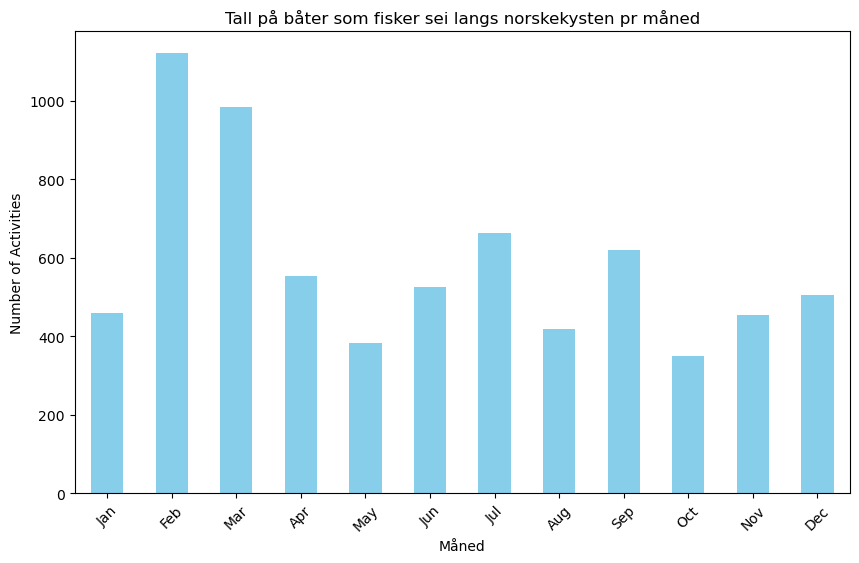

In [315]:
# Teller månedlig aktivitet.
monthly_counts = grouped_df.groupby('Month').size()

# Oppretter en serie for alle månedene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(monthly_counts)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Tall på båter som fisker sei langs norskekysten pr måned')
plt.xlabel('Måned')
plt.ylabel('Number of Activities')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()


#### aktiviteter pr måned
Vi ser her at det er mer aktivitet rundt seifiske i månedene februar og mars langs norskekysten. Det kan tenkes at dette har sammenheng med lofotfisket som foregår i månedene februar - april. 

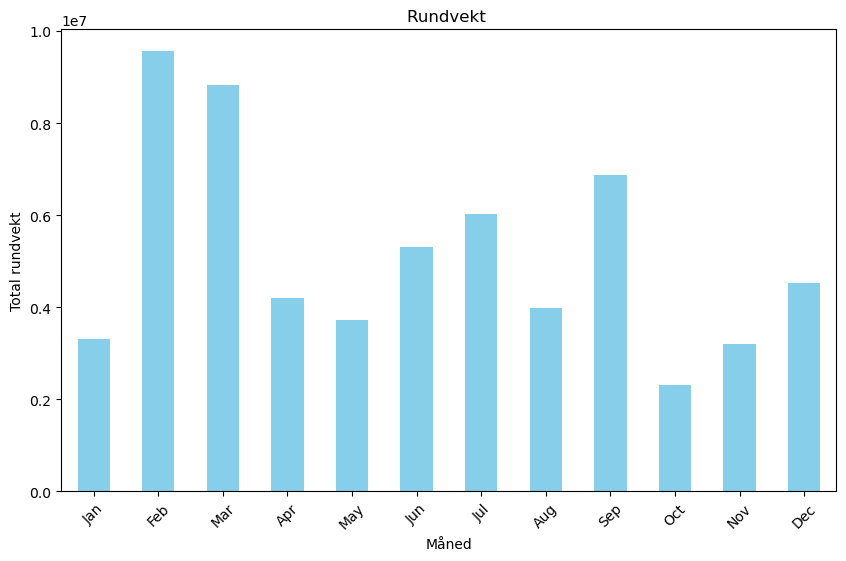

In [316]:
# Finner månedlig total rundvekt
monthly_weights = grouped_df.groupby('Month')['Rundvekt'].sum()

# Oppretter en serie for alle månedene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(monthly_weights)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Rundvekt ')
plt.xlabel('Måned')
plt.ylabel('Total rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

#### Samlet rundvekt av aktivitetene pr måned
Her ser vi tydelig sammenheng mellom månedene med stor aktivitet og den samlede rundvekten av aktivitetene.

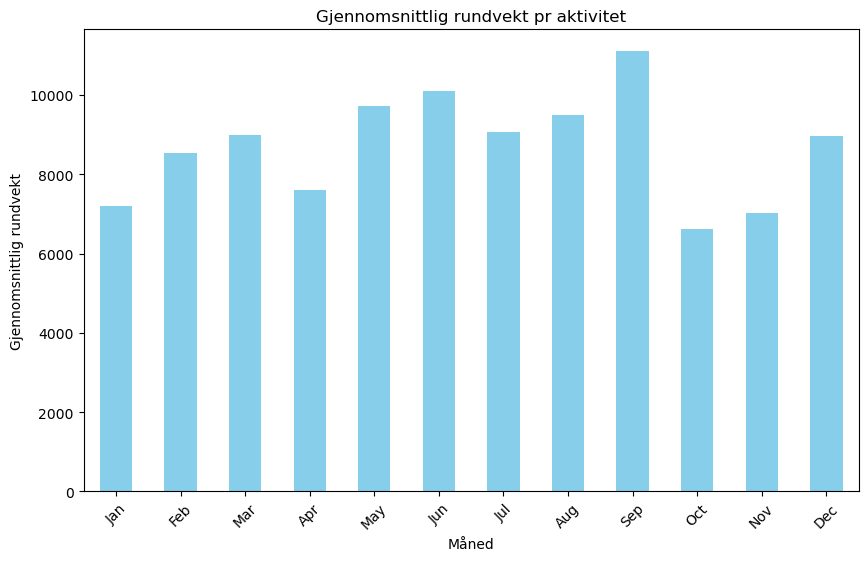

In [317]:
# Regner ut gjenomsnitt pr time
average_weights = monthly_weights/monthly_counts

# Oppretter en serie for alle timene i døgnet
all_months = pd.Series(0, index=range(1, 13))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_months.update(average_weights.astype(int))

# Generer et diagram
plt.figure(figsize=(10, 6))
all_months.plot(kind='bar', color='skyblue')
plt.title(f'Gjennomsnittlig rundvekt pr aktivitet')
plt.xlabel('Måned')
plt.ylabel('Gjennomsnittlig rundvekt')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

Ser her av gjennomsnittlig vekt at seifiske virker å være stabilt i den forstand at den forventede fangsten holder seg ganske stabil gjennom året.
September utmerker seg likevel som en måned hvor det er er forventet mer fisk.

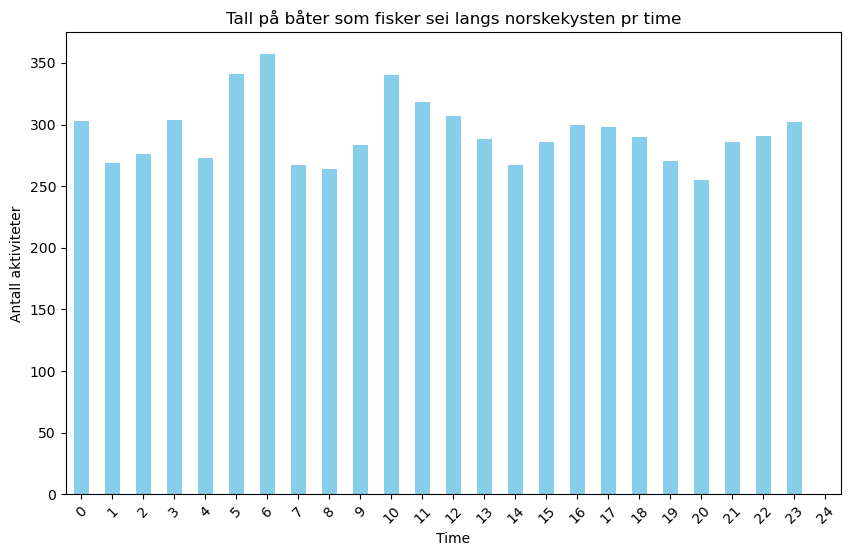

In [318]:
# Regner ut gjenomsnitt pr time
hourly_counts = grouped_df.groupby('Hours').size()

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_counts)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Tall på båter som fisker sei langs norskekysten pr time')
plt.xlabel('Time')
plt.ylabel('Antall aktiviteter')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()


Her ser vi hvordan fiskeaktivitetene av sei varierer i løpet av døgnet. Ser at det er en nokså stabil aktivitet gjennom døgnet. Her hadde vi forventet litt variasjoner.

Det er nå interessant å se på forholdet mellom aktivitetene og fangsten.

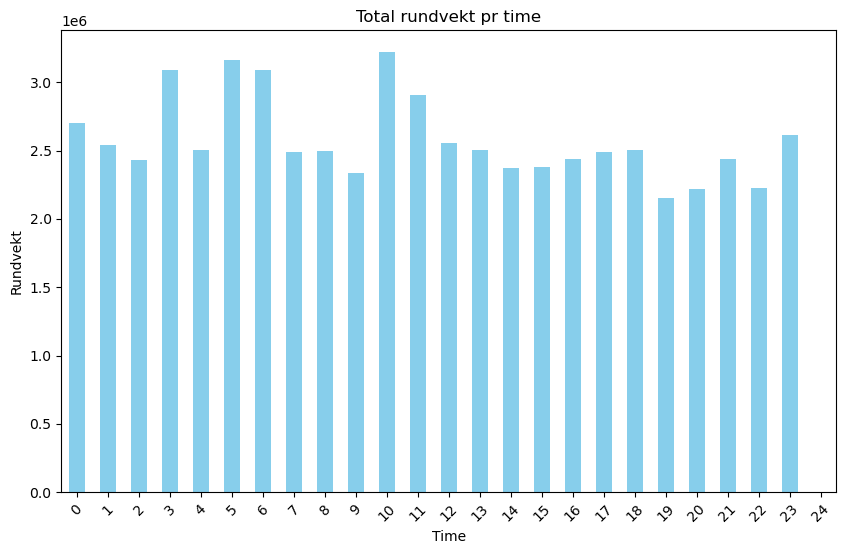

In [319]:
# Regner ut gjenomsnitt pr time
hourly_weights = grouped_df.groupby('Hours')['Rundvekt'].sum()

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_weights)

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Total rundvekt pr time')
plt.xlabel('Time')
plt.ylabel('Rundvekt')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()

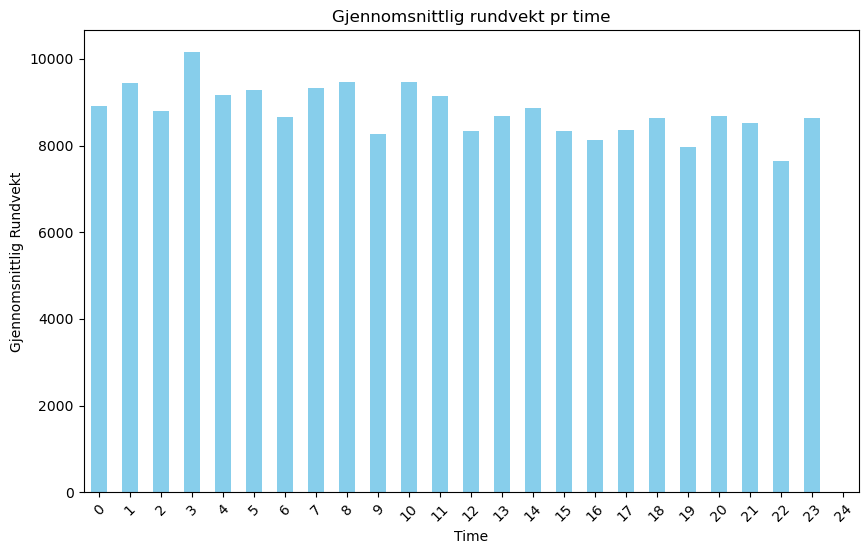

In [320]:
# Regner ut gjenomsnitt pr time
hourly_average = hourly_weights/hourly_counts

# Oppretter en serie for alle timene i døgnet
all_hours = pd.Series(0, index=range(0, 25))

# Oppdaterer serien ved å sette inn verdiene fra variabelen.
all_hours.update(hourly_average.astype(int))

# Generer et diagram
plt.figure(figsize=(10, 6))
all_hours.plot(kind='bar', color='skyblue')
plt.title(f'Gjennomsnittlig rundvekt pr time')
plt.xlabel('Time')
plt.ylabel('Gjennomsnittlig Rundvekt')
plt.xticks(range(25), [x for x in range (0,25)], rotation=45)
plt.show()

#### Tolking av data:
Det ser ut som seifisket med bunntrål fordeler seg ganske jevnt ut over døgnet og året, men med litt mer variasjon i løpet av året, og med den beste fangsmåneden i september om man ser på gjennomsnittlig fangst. Om noe forskjell i løpet av døgnet, så ser det ut som det det blir fanget noe mer fisk fra rundt midnatt til og med kl 11. 

Selv om det er lite variasjoner på døgnet, kan er det ikke sikkert dette er helt irrelevant for å predikere fiske. Det kan tenkes at det kan skyldes at fiske i nordlige deler på sommer eller vinterhalvåret gir naturlig en jevnere fordeling ila døgnet, siden forskjellene på natt og dag er mindre. Kanskje ville disse forskjellene være tydeligere i mer sørlige områder.


In [321]:
# Se på tid-kolonnene:   Check
    # Binne tid på døgnet   Chekc
    # Binne måneder    Check
# Se på statistikk: Check
# Gjøre om dato og tid til
# Fangst pr vektklasse - diagram
# Fangst pr område - diagram
# Fangst pr tid på døgnet
# Fangst pr årstid


In [322]:
grouped_df.Stoppklokkeslett.value_counts()

Stoppklokkeslett
00:02    27
00:01    24
09:27    18
00:10    15
00:00    15
         ..
06:42     1
17:24     1
20:46     1
14:36     1
00:44     1
Name: count, Length: 1418, dtype: int64

### 6: Slette kolonner:


In [323]:
grouped_df.columns


Index(['Melding ID', 'Meldingstidspunkt', 'Meldingsdato',
       'Meldingsklokkeslett', 'Starttidspunkt', 'Startdato',
       'Startklokkeslett', 'Startposisjon bredde', 'Startposisjon lengde',
       'Hovedområde start (kode)', 'Hovedområde start', 'Havdybde start',
       'Stopptidspunkt', 'Stoppdato', 'Stoppklokkeslett', 'Varighet',
       'Stopposisjon bredde', 'Stopposisjon lengde',
       'Hovedområde stopp (kode)', 'Hovedområde stopp', 'Havdybde stopp',
       'Trekkavstand', 'Redskap FDIR (kode)', 'Redskap FDIR',
       'Hovedart - FDIR (kode)', 'Rundvekt', 'Lengdegruppe (kode)',
       'Lengdegruppe', 'Bruttotonnasje 1969', 'Bruttotonnasje annen', 'Bredde',
       'Fartøylengde', 'Bruttotonnasje kombinert', 'Hours', 'Month'],
      dtype='object')

In [326]:

# Dropper kolonner: Vi hasher ut de kolonnene vi vil beholde.
grouped_df = grouped_df.drop(columns=[
    'Melding ID', 
    'Meldingstidspunkt', 
    'Meldingsdato', 
    'Meldingsklokkeslett', 
    'Starttidspunkt', 
    'Startdato', 
    #'Startklokkeslett', 
    #'Startposisjon bredde', 
    #'Startposisjon lengde', 
    #'Hovedområde start (kode)', 
    #'Hovedområde start', 
    #'Havdybde start', 
    'Stopptidspunkt', # Vi antar at det er liten forskjell på start og sluttidspunkt, så vi velger å droppe disse.
    'Stoppdato', 
    'Stoppklokkeslett', 
    'Varighet', 
    'Stopposisjon bredde', 
    'Stopposisjon lengde', 
    'Hovedområde stopp (kode)', 
    'Hovedområde stopp', 
    #'Havdybde stopp', Kan være interessant å se på senere
    #'Trekkavstand', 
    'Redskap FDIR (kode)', 
    #'Redskap FDIR', 
    #'Hovedart - FDIR (kode)', 
    #'Rundvekt', 
    'Lengdegruppe (kode)', 
    'Lengdegruppe', 
    'Bruttotonnasje 1969', 
    'Bruttotonnasje annen', 
    'Bredde', 
    'Fartøylengde', 
    #'Bruttotonnasje kombinert', 
    #'Hours', 
    #'Month'
    ])

grouped_df.describe()

,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Havdybde start,Havdybde stopp,Trekkavstand,Hovedart - FDIR (kode),Rundvekt,Bruttotonnasje kombinert,Hours,Month
count,7035,7035.000000,7035.000000,7035.000000,7035.000000,7035.000000,7035.000000,7035.0,7035.000000,7035.000000,7035.000000,7035.000000
mean,1900-01-01 11:53:20.230277376,66.735028,12.962406,8.415352,-189.052878,-191.842075,12604.629566,1032.0,8791.167306,1971.760625,11.403554,5.836389
min,1900-01-01 00:00:00,60.001000,2.005000,0.000000,-761.000000,-1276.000000,0.000000,1032.0,0.000000,129.000000,0.000000,1.000000
25%,1900-01-01 05:57:00,62.861000,5.317500,4.000000,-224.000000,-225.000000,4610.000000,1032.0,2902.000000,1194.000000,5.000000,3.000000
50%,1900-01-01 11:46:00,68.038000,10.873000,5.000000,-183.000000,-183.000000,9363.000000,1032.0,7170.000000,1853.000000,11.000000,6.000000
75%,1900-01-01 17:46:00,70.859000,20.489000,7.000000,-146.000000,-146.000000,17505.000000,1032.0,12306.500000,3104.000000,17.000000,9.000000
max,1900-01-01 23:59:00,71.998000,32.279000,28.000000,1.000000,-49.000000,233749.000000,1032.0,86506.000000,4427.000000,23.000000,12.000000
std,NaN,4.085970,8.253088,8.074137,65.521534,71.228941,11022.825233,0.0,7729.760254,1128.584191,6.880900,3.450505


Datacleaning:
Nullverdier.

Av df.describe leser vi først max og min verdier for å se om det er noen ekstreme eller usannsynlige verdier.
Rundvekt, 0 - registreringer. Ser at det er registreringer med verdien 0 i trekkavstand og rundvektkolonnen. Vi anser dette som feilregistreringer. Av trålens natur, at den soper store havområder, ser vi det som lite trolig at rundvekt 0 skal forekomme. Videre kan vi anta at registreringer med 0 i trekkavstand også er lite sannsynlig. 

Trekkavstand:
Vi ser at det ligger registreringer på over 200000 meter, det vil si 200 km eller 20 mil. Dette er store avstander for en trål som vanligvis opererer i snittfart på mellom 3,4 (6,3km/h) og 5 knop (9,26 km/h). I en snittfart på 10km/h så vil da trålen bruke over 20 timer. Med så lang varighet vil det være svært ugunstige forhold for fisken. 
Vi ser også at 5% av registreringene er over 35446m. Her ser vi også at med relativt høy fart, vil aktiviteten ha varighet på nærmere 4 timer. Ved å kutte registreringer over 50000 gir det oss en god margin på mulige feilregistreringer.

Dybde:
Vi ser det er registrert positive havdybde-verdier, i tillegg er det også registrert aktiviteter på -1276 dybde. Men de aller fleste aktivitetene er registrert mellom -227 og -145 meter. Fiskeridirektoratet beskriver at "Sei førekjem både pelagisk og som botnfisk, frå 0 til 300 meters djup." (https://www.hi.no/hi/temasider/arter/nordaustarktisk-sei) Vi mener det er sannsynlig at dette er enten en feilregistrering eller at fangsten er gjort når trålen er på vei opp av dypet. 



Ser av trekkavstand at det i 0-registreringene av trekkavstand også fanges fisk. Dette gir ikke mening med tanke på at det følgelig må trekkes en viss avstand for å få fisk.

Ser også her at det er registrert forskjellige arter i 0-registrerningene på rundvekt. Det er da fornuftig å anta at dette enten er feilregistreringer eller fangst uten betydning.

In [330]:
# Fjerner radene med data nevnt over:
# Droppe tomme rader.
cleaned_df = grouped_df.copy().dropna()
# Konvertere positive Havdybdeverdier
cleaned_df['Havdybde stopp'] = cleaned_df['Havdybde stopp'].abs()
# Ta vekk havdybder på over 10 m, for å fjerne usannsynlige tråledybder.
cleaned_df = cleaned_df[cleaned_df['Havdybde stopp'] > 10]
# Droppe trekkavstand på over 50000 m.
cleaned_df = cleaned_df[(cleaned_df['Trekkavstand'] > 0) & (cleaned_df['Trekkavstand'] < 50000)]
# Her kan vi kanskje undersøke

# Droppe ekstreme Bruttotonnasjeverdier.
cleaned_df = cleaned_df[(cleaned_df['Bruttotonnasje kombinert'] > 400) & (cleaned_df['Bruttotonnasje kombinert'] < 4000)]
# Droppe registreringer i områder som ikkje er i Norsk farvatn. Startposisjon med mindre enn 0.
cleaned_df = cleaned_df[cleaned_df['Startposisjon lengde'] > 0]
cleaned_df = cleaned_df[cleaned_df['Startposisjon bredde'] > 0]
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6499 entries, 0 to 7034
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Startklokkeslett          6499 non-null   datetime64[ns]
 1   Startposisjon bredde      6499 non-null   float64       
 2   Startposisjon lengde      6499 non-null   float64       
 3   Hovedområde start (kode)  6499 non-null   float64       
 4   Hovedområde start         6499 non-null   object        
 5   Havdybde start            6499 non-null   int64         
 6   Havdybde stopp            6499 non-null   int64         
 7   Trekkavstand              6499 non-null   float64       
 8   Redskap FDIR              6499 non-null   object        
 9   Hovedart - FDIR (kode)    6499 non-null   float64       
 10  Rundvekt                  6499 non-null   float64       
 11  Bruttotonnasje kombinert  6499 non-null   float64       
 12  Hours                    

Endre format på kolonnene til riktig format:
Her ser vi at 

Ser av value_counts at de mest vanlige redskapene er bunntrål og snurrevad. Her er det så mye data at vi fokuserer videre på dette. (Usikker på å inkludere snurrevad.

df['Redskap

In [ ]:
# Antall registreringer med dei forskjellige Hovedarter.
print(df['Hovedart FAO'].value_counts())

Hovedart FAO
Torsk                   86215
Sei                     66311
Dypvannsreke            36977
Hyse                    28176
Lange                   13387
                        ...  
Sandflyndre                 3
Makrellstørje               2
Various squids nei *        2
Blåhval                     1
Annen laksefisk             1
Name: count, Length: 68, dtype: int64


In [ ]:
# Få oversikt over hovedområder.
hovedområder = df.groupby(df['Hovedområde start'], as_index= False).agg(
    {'Hovedområde start': 'first', 'Hovedområde start (kode)': 'first'}
)
print(hovedområder)

                Hovedområde start  Hovedområde start (kode)
0                Admiralityfeltet                      16.0
1                        Bjørnøya                      20.0
2                   Britvinfeltet                      14.0
3                  Danmarkstredet                      61.0
4                 Eigersundbanken                       8.0
5                     Flemish Cap                      81.0
6                     Fyllas Bank                      68.0
7                     Færøybanken                      58.0
8                       Gammelock                      62.0
9                  Grønlandshavet                      26.0
10                     Gåsebanken                      11.0
11               Helgelandsbanken                       6.0
12                          Hopen                      23.0
13                    Kaninbanken                       1.0
14                 Murmanskkysten                       2.0
15         Nord av Horn  (Island)       

In [ ]:
# Undersøker hvor det er flest aktiviteter
print(df['Hovedområde start'].value_counts())

Hovedområde start
Eigersundbanken                  45349
Røstbanken til Malangsgrunnen    29099
Vest-Finnmark                    27711
Øst-Finnmark                     26995
Bjørnøya                         25265
Shetland                         24813
Nordkappbanken                   18635
Vikingbanken                     16600
Skagerrak                        16097
Storegga-Frøyabanken             14884
Helgelandsbanken                  8591
Sentralbanken                     5584
Storbanken                        4823
Thor Iversens Bank                4551
Vestfjorden (Lofoten)             4469
Sentrale Nordsjø                  3387
Hopen                             3161
Vest av Skottland (Hebridene)     2008
Sørlige Norskehav                 1990
Østlige Norskehav                 1936
Admiralityfeltet                  1909
Skolpenbanken                     1904
Gåsebanken                        1699
Storfjord/Hinlopenstredet         1363
Vest-Spitsbergen                  1242
Vest av

In [ ]:
# Undersøker hvilke arter som er de mest frekvente i Eigersundbanken.
eigersundbanken = df[df['Hovedområde start'] == 'Eigersundbanken']
eigersundbanken['Hovedart FAO'].value_counts()

Hovedart FAO
Dypvannsreke            15214
Sei                      8117
Øyepål                   4813
Torsk                    3586
Lysing                   3244
Kolmule                  3148
Breiflabb                1347
Tobis og annen sil       1177
Sild                     1105
Hestmakrell               850
Lange                     484
Hyse                      383
Lyr                       246
Strømsild                 199
Strømsild/Vassild         163
Rødspette                 161
Brosme                     81
Gråsteinbit                79
Sølvtorsk                  70
Sjøkreps                   69
Hvitting                   31
Stortare                   26
Makrell                    25
Skjellbrosme               21
Steinbiter                 20
Kveite                     17
Lomre                      15
Pigghå                     13
Annen torskefisk           12
Annen skate og rokke       12
Rognkjeks (felles)          8
Hakes nei. *                8
Flekksteinbit              

In [ ]:
# Antall registreringer av fisk som ikkje er hovedart.
condition = df[(df['Hovedart FAO'] != df['Art FAO'])]
condition['Art FAO'].value_counts()

Art FAO
Torsk                   31512
Hyse                    31341
Sei                     23976
Lange                   14924
Uer (vanlig)            13906
                        ...  
Annen makrell               1
Various squids nei *        1
Taskekrabbe                 1
Sagtang                     1
Annen torskefisk            1
Name: count, Length: 110, dtype: int64

In [ ]:
# Aktuelle redskaper å bruke: Bunntrål, Snurrevad og muligens Andre Liner. evt, dobbeltål
# Unngå garn.
# Aktuelle fisketyper å bruke hovedfangst: Sei
fish_types = ['Sei']
# Aktuelle Redskaper: Bunntrål, Snurrevad, Andre liner, (Dobbeltrål)
tools = ['Bunntrål']  # , 'Snurrevad', 'Andre liner'
# Aktuelle områder:
#areas = [x for x in range(0, 70)] # alle hovedområder minus antarktis og fiske i andre hav.
areas = [8, 42, 28, 7]

condition_3 = df['Hovedområde start (kode)'].isin(areas)
condition_1 = df['Hovedart FAO'].isin(fish_types) 
condition_2 = df['Redskap FDIR'].isin(tools)
combined_condition = condition_1 & condition_2 & condition_3
filtered_df = df[combined_condition].copy()
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21253 entries, 90 to 305299
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Melding ID                21253 non-null  int64  
 1   Meldingstidspunkt         21253 non-null  object 
 2   Meldingsdato              21253 non-null  object 
 3   Meldingsklokkeslett       21253 non-null  object 
 4   Starttidspunkt            21253 non-null  object 
 5   Startdato                 21253 non-null  object 
 6   Startklokkeslett          21253 non-null  object 
 7   Startposisjon bredde      21253 non-null  float64
 8   Startposisjon lengde      21253 non-null  float64
 9   Hovedområde start (kode)  21253 non-null  float64
 10  Hovedområde start         21253 non-null  object 
 11  Lokasjon start (kode)     21253 non-null  float64
 12  Havdybde start            21253 non-null  int64  
 13  Stopptidspunkt            21253 non-null  object 
 14  Stoppdato

In [ ]:
filtered_df.loc[:, 'Bruttotonnasje kombinert'] = filtered_df['Bruttotonnasje 1969'].fillna(filtered_df['Bruttotonnasje annen'])

for start_stop in ['Startklokkeslett', 'Stoppklokkeslett']:
    # Konvertere klokkeslett til relevant verdi
    filtered_df[start_stop] = pd.to_datetime(filtered_df[start_stop], format='%H:%M').dt.strftime('%H-%M')
    # Konverter til Desimal-timer.
    filtered_df[f'{start_stop}_DecimalHours'] = filtered_df[start_stop].str.split('-').apply(lambda x: int(x[0]) + int(x[1]) / 60)
    # Konverter til Radianer.
    filtered_df[f'{start_stop}_Radians'] = filtered_df[f'{start_stop}_DecimalHours'] * (2 * np.pi / 24)
    # Regne ut sinus og cosinus.
    filtered_df[f'{start_stop}_TimeSin'] = np.sin(filtered_df[f'{start_stop}_Radians'])
    filtered_df[f'{start_stop}_TimeCos'] = np.cos(filtered_df[f'{start_stop}_Radians'])

In [ ]:
filtered_df = filtered_df.drop(columns = [
    'Fangstår', 
    #'Melding ID', 
    'Meldingstidspunkt', 
    'Meldingsdato',
    'Meldingsklokkeslett', 
    'Starttidspunkt',
    'Startklokkeslett',
    #'Hovedområde start (kode)', 
    'Hovedområde start',
    'Lokasjon start (kode)', 
    'Havdybde start', 
    'Stopptidspunkt',
    'Varighet',
    'Stoppdato', 
    'Startposisjon bredde',
    'Startposisjon bredde',
    #'Stoppklokkeslett', 
    #'Stopposisjon bredde', 
    #'Stopposisjon lengde',
    'Hovedområde stopp (kode)', 
    'Hovedområde stopp',
    'Lokasjon stopp (kode)', 
    'Redskap FAO (kode)', 
    'Redskap FDIR (kode)',
    'Hovedart FAO (kode)',
    'Hovedart - FDIR (kode)', 
    'Art FAO (kode)', 
    #'Art FAO',
    'Art - FDIR (kode)', 
    'Art - FDIR', 
    'Art - gruppe (kode)',
    #'Art - gruppe', 
    'Lengdegruppe (kode)', 
    'Lengdegruppe',
    'Bredde',
    'Fartøylengde',
    'Bruttotonnasje 1969',
    'Bruttotonnasje annen'
    ])

In [ ]:
# Droppe tomme rader.
cleaned_df = grouped_df.copy().dropna()
# Konvertere positive Havdybdeverdier
cleaned_df['Havdybde stopp'] = cleaned_df['Havdybde stopp'].abs()
# Ta vekk havdybder på over 10 m, for å fjerne usannsynlige tråledybder.
cleaned_df = cleaned_df[cleaned_df['Havdybde stopp'] > 10]
# Droppe trekkavstand på over ei viss lengd.
cleaned_df = cleaned_df[(cleaned_df['Trekkavstand'] > 10) & (cleaned_df['Trekkavstand'] < 60000)]

# Droppe ekstreme Bruttotonnasjeverdier. Under
cleaned_df = cleaned_df[(cleaned_df['Bruttotonnasje kombinert'] > 400) & (cleaned_df['Bruttotonnasje kombinert'] < 4000)]
# Droppe registreringer i områder som ikkje er i Norsk farvatn. Startposisjon med mindre enn 0.
cleaned_df = cleaned_df[cleaned_df['Stopposisjon lengde'] > 0]
cleaned_df = cleaned_df[cleaned_df['Stopposisjon bredde'] > 0]
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3889 entries, 0 to 5741
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Melding ID                     3889 non-null   int64  
 1   Stopposisjon lengde            3889 non-null   float64
 2   Stopposisjon bredde            3889 non-null   float64
 3   Stoppklokkeslett               3889 non-null   object 
 4   Stoppklokkeslett_DecimalHours  3889 non-null   float64
 5   Stoppklokkeslett_Radians       3889 non-null   float64
 6   Stoppklokkeslett_TimeSin       3889 non-null   float64
 7   Hovedområde start (kode)       3889 non-null   float64
 8   Havdybde stopp                 3889 non-null   int64  
 9   Trekkavstand                   3889 non-null   float64
 10  Redskap FDIR                   3889 non-null   object 
 11  Hovedart FAO                   3889 non-null   object 
 12  Art FAO                        3889 non-null   object

In [ ]:
# Lager en liste med features
all_features = [
    'Stopposisjon lengde', 
    'Stopposisjon bredde', 
    'Stoppklokkeslett_Radians', 
    'Havdybde stopp', 
    'Trekkavstand',  
    'Rundvekt',
    'Bruttotonnasje kombinert'
]

cleaned_df[all_features]

,Stopposisjon lengde,Stopposisjon bredde,Stoppklokkeslett_Radians,Havdybde stopp,Trekkavstand,Rundvekt,Bruttotonnasje kombinert
0,2.134,61.278,0.842121,211,29124.0,30000.0,2053.0
1,1.982,61.343,2.255838,158,1972.0,17000.0,2053.0
2,1.702,61.552,3.691371,264,27885.0,20000.0,2053.0
3,1.885,61.401,5.628687,180,16590.0,3000.0,2053.0
4,5.664,63.401,5.842490,311,34192.0,1685.0,536.0
...,...,...,...,...,...,...,...
5737,5.417,63.151,5.057092,176,4119.0,7330.0,567.0
5738,4.093,62.654,2.474004,185,14460.0,3000.0,2053.0
5739,4.082,62.656,4.057891,191,2157.0,6860.0,2053.0
5740,4.802,62.778,5.218534,145,17655.0,650.0,2053.0


In [ ]:
# Importerer verktøy for å kalkulere feil i modellen - gjennomsnittlig feil?
from sklearn.metrics import mean_absolute_error

# Lager en for-loop for å generere resultater for ulike target-values.
for predict in all_features:
    features = [f for f in all_features if f != predict]
    X = cleaned_df[features]
    y = cleaned_df[predict]

    # Definerer X og y, X er features, y er målverdien (target value)
    X = cleaned_df[features]
    y = cleaned_df[predict]

    # Splitter settet i train_dfsett og train_dfsett - Da kan man sammenligne prediksjonene mot et train_df-sett
    X_train_df, X_val, y_train_df, y_val = train_df_train_df_split(X, y, train_df_size=0.2, random_state=1)

    # Velger MLmodell
    fishery_model = DecisionTreeRegressor(random_state=1)

    # Trener(?) modellen på train_df-settet
    fishery_model.fit(X_train_df, y_train_df)

    # Prediksjoner - predikerer tar X-val verdiene og predikerer rundvekt basert på disse tallene.
    val_predictions = fishery_model.predict(X_val)

    # Sammenligner et utvalg (X-val.head()) av prediksjoner mot relaterte y_val.head()
    print(f'--------- Target value: {predict} -------')
    print(fishery_model.predict(X_val.head()))
    print(y_val.head())

    # Tar inn y_val verdiene og regner ut gjennomsnittlig feil mellom prediksjonene og train_df-verdiene(val_y)
    val_mae = mean_absolute_error(y_val, val_predictions)
    print(f'\nMean absolute error: {val_mae}')
    print(f'\nScore: {fishery_model.score(X_val, y_val)}\n')


NameError: name 'train_df_train_df_split' is not defined

In [ ]:
for predict in all_features:
    features = [f for f in all_features if f != predict]
    X = cleaned_df[features]
    y = cleaned_df[predict]

    # Definerer X og y, X er features, y er målverdien (target value)
    X = cleaned_df[features]
    y = cleaned_df[predict]

    # Splitter settet i train_dfsett og train_dfsett - Da kan man sammenligne prediksjonene mot et train_df-sett
    X_train_df, X_val, y_train_df, y_val = train_df_train_df_split(X, y, train_df_size=0.2, random_state=1)

    # Velger MLmodell
    fishery_model = linear_model.LinearRegression()

    # Trener(?) modellen på train_df-settet
    fishery_model.fit(X_train_df, y_train_df)

    # Prediksjoner - predikerer tar X-val verdiene og predikerer rundvekt basert på disse tallene.
    val_predictions = fishery_model.predict(X_val)

    # Sammenligner et utvalg (X-val.head()) av prediksjoner mot relaterte y_val.head()
    print(f'--------- Target value: {predict} -------')
    print(fishery_model.predict(X_val.head()))
    print(y_val.head())

    # Tar inn y_val verdiene og regner ut gjennomsnittlig feil mellom prediksjonene og train_df-verdiene(val_y)
    val_mae = mean_absolute_error(y_val, val_predictions)
    print(f'\nMean absolute error: {val_mae}')
    print(f'\nScore: {fishery_model.score(X_val, y_val)}\n')

--------- Target value: Stopposisjon lengde -------
[5.74487152 4.05586829 2.56093869 3.01273609 2.27730655]
1154    5.567
3740    2.985
4175    3.179
2687    5.365
185     1.586
Name: Stopposisjon lengde, dtype: float64

Mean absolute error: 1.0623234127851642

Score: 0.36408984593499305

--------- Target value: Stopposisjon bredde -------
[61.97829529 61.04372911 60.74440462 63.66076214 61.86259817]
1154    62.735
3740    60.497
4175    59.546
2687    63.222
185     61.635
Name: Stopposisjon bredde, dtype: float64

Mean absolute error: 0.9333871471614158

Score: 0.2655660617371204

--------- Target value: Stoppklokkeslett_Radians -------
[3.00546345 2.96434221 3.28146471 2.93284063 2.91050448]
1154    2.530727
3740    4.886922
4175    1.042834
2687    5.183628
185     1.282817
Name: Stoppklokkeslett_Radians, dtype: float64

Mean absolute error: 1.552494529114616

Score: 0.005107744166126915

--------- Target value: Havdybde stopp -------
[155.12013152 166.08366247 153.11320383 160.32